# Resampling and Logistic Regression

Here's a [question from Reddit's statistics forum](https://www.reddit.com/r/statistics/comments/10ayfm5/q_parametric_bootstrap_for_logistic_regression/):

> I am trying to do parametric bootstrap for logistic regression but I don't know what the random error terms should be. I know how to do it with linear regression since the error terms follow a normal distribution. Really appreciate any pointers to resources about this topic.

One of the responses recommends [this paper](https://www.scirp.org/journal/paperinformation.aspx?paperid=70962): "An Application of Bootstrapping in Logistic Regression Model", by Isaac Akpor Adjei and Rezaul Karim.

The paper suggests two ways to compute the sampling distribution of the parameters of a logistic regression by bootstrap sampling.
They characterize one as parametric and the other as non-parametric, and advise:

> The non-parametric bootstrap [relies] on weaker assumptions (or no assumptions at all) about the underlying distribution of the population. Statistical practitioners should use non-parametric procedures only in so far as the assumptions about the underlying distribution are seriously doubtful in their validity. ... However, when assumptions are not violated, non-parametric procedures will usually have greater variance (in point estimation), less power (in hypothesis testing), wider intervals (in confidence interval estimation), lower probability of correct selection (in ranking and selection) and higher risk (in decision theory) when compared to a corresponding parametric procedure (Efron and Tibshirani, 1994 [1] ).

The premise of this advice is that the parametric and non-parametric methods are answering the same question in different ways, and that one might be preferred over the other because the results are preferable in one way or another. It is also based on the assumption that the sampling distribution of the parameters -- and the statistics derived from it -- are uniquely and objectively defined.

I disagree with these premises. The parametric and non-parametric methods they present are based on different modeling decisions, so they compute answers to different questions.
And the models they are based on are only two of many possible models.

To explain what I mean, I will implement the methods they propose and explain the assumptions each is based on. Then I will propose a third method that is a hybrid of the two. I'll show that all three methods yield different results, and suggest criteria for when one might be preferred over the others.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/resample_logit.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## The Data

As an example, I'll use data from the General Social Survey (GSS).
I'll download an HDF file from the *Elements of Data Science* repository, which contains a subset of the GSS data that has been resampled to correct for stratified sampling.

In [4]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/gss_eda.hdf')

In [5]:
gss = pd.read_hdf('gss_eda.hdf', 'gss')
gss.shape

(64814, 8)

It includes 64,814 respondents and 8 variables for each respondent.

In [6]:
gss.head()

,YEAR,ID_,AGE,EDUC,SEX,GUNLAW,GRASS,REALINC
0,1972,1,23.0,16.0,2,1.0,NaN,18951.0
1,1972,2,70.0,10.0,1,1.0,NaN,24366.0
2,1972,3,48.0,12.0,2,1.0,NaN,24366.0
3,1972,4,27.0,17.0,2,1.0,NaN,30458.0
4,1972,5,61.0,12.0,2,1.0,NaN,50763.0


To demonstrate logistic regression, I'll use [one of the questions](https://gssdataexplorer.norc.org/variables/285/vshow) in the General Social Survey, which asks "Do you think the use of marijuana should be made legal or not?"
The responses are in a column called `GRASS` -- here are the values.  

In [7]:
gss['GRASS'].value_counts()

GRASS
2.0    25662
1.0    11884
Name: count, dtype: int64

I'll use StatsModels, which provides a function that does logistic regression.
First we have to recode the dependent variable so `1` means "yes" and `0` means "no".  We can do that by replacing `2` with `0`.

In [8]:
gss['GRASS'] = gss['GRASS'].replace(2, 0)

To model quadratic relationships, I'll add columns that contain the values of `AGE` and `EDUC` squared.

In [9]:
gss['AGE2'] = gss['AGE']**2
gss['EDUC2'] = gss['EDUC']**2

And I'll drop the rows that have missing values for the variables we'll need.

In [10]:
data = gss.dropna(subset=['AGE', 'EDUC', 'SEX', 'GUNLAW', 'GRASS'])

## Logistic Regression

Here are the results of logistic regression with these variables.

In [11]:
import statsmodels.formula.api as smf

formula = 'GRASS ~ AGE + AGE2 + EDUC + EDUC2 + C(SEX)'
result_hat = smf.logit(formula, data=data).fit()
result_hat.summary()

Optimization terminated successfully.
         Current function value: 0.593464
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  GRASS   No. Observations:                20475
Model:                          Logit   Df Residuals:                    20469
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.05003
Time:                        15:30:02   Log-Likelihood:                -12151.
converged:                       True   LL-Null:                       -12791.
Covariance Type:            nonrobust   LLR p-value:                1.555e-274
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.6788      0.240     -6.988      0.000      -2.150      -1.208
C(SEX)[T.2]    -0.3849      0.031    -12.394      0.000      -0.446      -0.324
AGE            -0.0278      0.005     -5.399      0.000      -0.038      -0.018
AGE2            0.0001   5.28e-05      2.190      0.029    1.21e-05       0.000
EDUC            0.2000      0.031      6.412      0.000       0.139       0.261
EDUC2          -0.0029      0.001     -2.450      0.014      -0.005      -0.001
===============================================================================
"""

To get a sense of what the results look like, we can plot the predicted probability of saying  "yes" as a function of age, for male and female respondents.

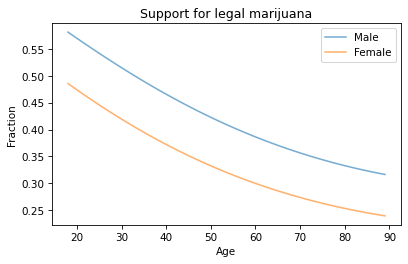

In [12]:
df = pd.DataFrame()
df['AGE'] = np.linspace(18, 89)
df['EDUC'] = 16

df['AGE2'] = df['AGE']**2
df['EDUC2'] = df['EDUC']**2

df['SEX'] = 1
pred1 = result_hat.predict(df)
pred1.index = df['AGE']

df['SEX'] = 2
pred2 = result_hat.predict(df)
pred2.index = df['AGE']

pred1.plot(label='Male', alpha=0.6)
pred2.plot(label='Female', alpha=0.6)

plt.xlabel('Age')
plt.ylabel('Fraction')
plt.title('Support for legal marijuana')
plt.legend();

Men are more likely to support legalization than women, and younger people more likely than older people.

## Boostrap sampling

Now let's implement the method characterized as non-parametric, which is based on bootstrap resampling.
The following function samples the rows of `data` with replacement and runs the regression model on the resampled data.

In [21]:
options = dict(disp=False, start_params=result_hat.params) 

def bootstrap(i):
    np.random.seed(i)
    bootstrapped = data.sample(n=len(data), replace=True)
    results = smf.logit(formula, data=bootstrapped).fit(**options)
    return results.params

The options sent to `fit` make it run faster, but don't affect the results by much.

Each time we run this process, the result represents a single draw from the sampling distribution of the parameters.

In [22]:
bootstrap(0)

Intercept     -1.861770
C(SEX)[T.2]   -0.380758
AGE           -0.021963
AGE2           0.000034
EDUC           0.209531
EDUC2         -0.002996
dtype: float64

By running it many times, we generate a sample from the sampling distribution. `pqdm` runs the sampling process in multiple threads.

In [23]:
try:
    from pqdm.threads import pqdm
except ImportError:
    !pip install pqdm
    from pqdm.threads import pqdm

In [24]:
estimates = pqdm(range(101), bootstrap, n_jobs=4)
sampling_dist = pd.DataFrame(estimates)
sampling_dist.head()

QUEUEING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/101 [00:00<?, ?it/s]

,Intercept,C(SEX)[T.2],AGE,AGE2,EDUC,EDUC2
0,-1.861770,-0.380758,-0.021963,0.000034,0.209531,-0.002996
1,-1.870006,-0.343399,-0.024615,0.000093,0.211290,-0.003338
2,-1.550265,-0.422493,-0.031421,0.000166,0.196451,-0.002947
3,-1.913072,-0.342552,-0.022696,0.000073,0.208549,-0.002995
4,-1.709399,-0.385184,-0.025895,0.000106,0.193661,-0.002584


Here's what the sampling distribution looks like for one of the parameters.

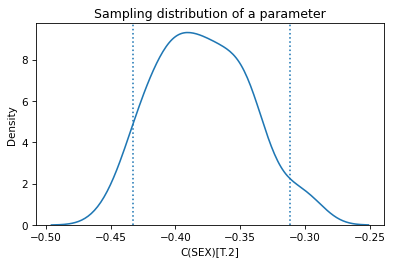

In [25]:
ci90 = sampling_dist['C(SEX)[T.2]'].quantile([0.05, 0.95])
sns.kdeplot(sampling_dist['C(SEX)[T.2]'])
[plt.axvline(x, ls=':') for x in ci90]
plt.title('Sampling distribution of a parameter');

The mean of the sampling distribution should be close to the parameters we estimated with the original dataset, and it is.

In [26]:
pd.DataFrame({"Sampling mean": sampling_dist.mean(), 
              "Estimates": result_hat.params})

,Sampling mean,Estimates
Intercept,-1.699398,-1.678838
C(SEX)[T.2],-0.379244,-0.384919
AGE,-0.027387,-0.027825
AGE2,0.000110,0.000116
EDUC,0.201980,0.200002
EDUC2,-0.002937,-0.002855


The standard deviations of the sampling distributions should be close to the standard errors computed by StatsModels, and they are.
Most of them are close enough that the difference probably doesn't matter in practice.

In [27]:
def standard_errors(sampling_dist, result_hat):
    df = pd.DataFrame({"Sampling std": sampling_dist.std(), 
                       "Standard error": result_hat.bse})
    num, den = df.values.T
    df['Percent diff'] = (num / den - 1) * 100
    return df

In [28]:
standard_errors(sampling_dist, result_hat)

,Sampling std,Standard error,Percent diff
Intercept,0.256191,0.240243,6.638413
C(SEX)[T.2],0.036286,0.031057,16.838207
AGE,0.004992,0.005153,-3.141741
AGE2,0.000052,0.000053,-1.399085
EDUC,0.034325,0.031193,10.041461
EDUC2,0.001263,0.001166,8.386875


Of course, there is nothing magic about the standard errors computed by StatsModels -- they are approximations based on a model of the sampling process, just like the results from resampling.

## The Resampling Framework

The purpose of the sampling distribution is to quantify the variability in an estimate due to random sampling. It is the answer to the question, "If we ran this sampling process many times, how much would we expect the results to vary?"

To answer that question, we need a model of the sampling process. We use the model to simulate the sampling process and generate counterfactual datasets that represent other samples the process could have generated.

The following figure represents this framework.

<img src="https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png" width="500">

In bootstrap resampling, we treat the rows of the original dataset as if they are the population and draw a random sample from it.
We use this simulated data to compute the sample statistic; in this example, it's the parameters of the logistic regression model.
We collect the results to form a sample from the sampling distribution, which we can use to compute confidence intervals and standard errors.

This way of simulating the sampling process asks, in effect, what would have happened if we had surveyed different people.
But that's not the only possible model of the sampling process.
An alternative is to ask what would happen if we surveyed the same people, but they gave different answers.
That's the model that underlies the parametric method.

## Parametric bootstrap

So, how do we simulate a sampling process where we survey the same people, but they give different answers?
One way is to assume, for the purposes of the simulation, that the parameters we estimated from the original data are correct.
If so, we can use the regression model to compute the predicted probability for each respondent, like this:

In [29]:
pi_hat = result_hat.predict(data)
pi_hat.describe()

count    20475.000000
mean         0.317167
std          0.113654
min          0.025989
25%          0.234792
50%          0.317927
75%          0.400791
max          0.630366
dtype: float64

Now we can use these probabilities to generate a biased coin toss for each respondent.

In [30]:
from scipy.stats import bernoulli

simulated = bernoulli.rvs(pi_hat.values)
simulated.mean()

0.3184371184371184

Then we can run the regression model with these simulated values as the dependent variable.
The following function shows how.

In [31]:
def bootstrap2(i):
    np.random.seed(i)
    flipped = data.assign(GRASS=bernoulli.rvs(pi_hat.values))
    results = smf.logit(formula, data=flipped).fit(**options)
    return results.params

Again, the result from a single simulation is a random value from the sampling distribution.

In [32]:
bootstrap2(0)

Intercept     -1.441101
C(SEX)[T.2]   -0.337146
AGE           -0.025234
AGE2           0.000088
EDUC           0.155658
EDUC2         -0.001490
dtype: float64

If we run it many times, we get a sample from the sampling distribution.

In [33]:
from pqdm.threads import pqdm

estimates = pqdm(range(101), bootstrap2, n_jobs=4)

QUEUEING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/101 [00:00<?, ?it/s]

In [34]:
sampling_dist2 = pd.DataFrame(estimates)
sampling_dist2.head()

,Intercept,C(SEX)[T.2],AGE,AGE2,EDUC,EDUC2
0,-1.607550,-0.337807,-0.030948,0.000152,0.194980,-0.002592
1,-1.744398,-0.371315,-0.030606,0.000140,0.214210,-0.003249
2,-2.028428,-0.382518,-0.023002,0.000059,0.247973,-0.004799
3,-1.888331,-0.388846,-0.028548,0.000146,0.234939,-0.004520
4,-1.488713,-0.391091,-0.028701,0.000100,0.187119,-0.002527


Here's the sampling distribution for a single parameter.

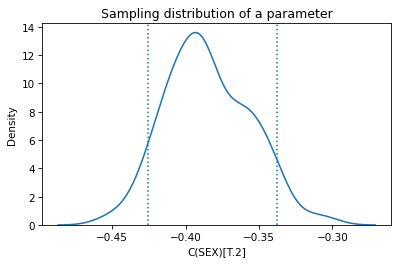

In [35]:
ci90 = sampling_dist2['C(SEX)[T.2]'].quantile([0.05, 0.95])
sns.kdeplot(sampling_dist2['C(SEX)[T.2]'])
[plt.axvline(x, ls=':') for x in ci90]
plt.title('Sampling distribution of a parameter');

Again, the standard deviations should be close to the standard errors, and they are.

In [36]:
standard_errors(sampling_dist2, result_hat)

,Sampling std,Standard error,Percent diff
Intercept,0.213665,0.240243,-11.062937
C(SEX)[T.2],0.028567,0.031057,-8.015624
AGE,0.004358,0.005153,-15.429475
AGE2,0.000047,0.000053,-10.980252
EDUC,0.030602,0.031193,-1.892655
EDUC2,0.001166,0.001166,-0.006701


So we have two models of the sampling process that yield different sampling distributions. But these are not the only models.

If the first method asks, "What if we surveyed different people?" and the second asks "What if we surveyed the same people and they gave different answers?", let's consider a third method that asks "¿Por qué no los dos?".

## The Hybrid Model

The following function uses bootstrap sampling to simulate surveying different people; then it uses the parametric method to simulate their responses.

In [37]:
def bootstrap3(i):
    np.random.seed(i)
    bootstrapped = data.sample(n=len(data), replace=True)
    pi_hat = result_hat.predict(bootstrapped)
    flipped = bootstrapped.assign(GRASS=bernoulli.rvs(pi_hat.values))
    results = smf.logit(formula, data=flipped).fit(**options)
    return results.params

In [38]:
bootstrap3(0)

Intercept     -1.175861
C(SEX)[T.2]   -0.381466
AGE           -0.037683
AGE2           0.000208
EDUC           0.153999
EDUC2         -0.001051
dtype: float64

In [39]:
from pqdm.threads import pqdm

estimates = pqdm(range(101), bootstrap3, n_jobs=4)

QUEUEING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/101 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/101 [00:00<?, ?it/s]

In [40]:
sampling_dist3 = pd.DataFrame(estimates)
sampling_dist3.head()

,Intercept,C(SEX)[T.2],AGE,AGE2,EDUC,EDUC2
0,-1.292261,-0.415617,-0.029380,0.000135,0.150813,-0.001118
1,-1.703202,-0.351606,-0.028947,0.000139,0.209984,-0.003611
2,-1.236159,-0.417756,-0.034266,0.000176,0.154023,-0.000940
3,-1.894601,-0.314302,-0.018581,0.000029,0.183858,-0.001909
4,-1.290408,-0.425398,-0.036473,0.000200,0.169032,-0.001666


Here's the sampling distribution for one of the parameters.

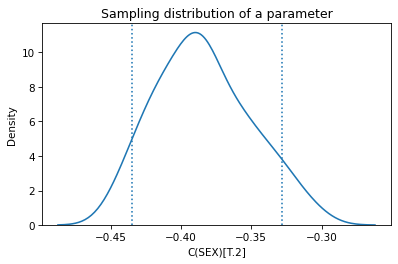

In [41]:
ci90 = sampling_dist3['C(SEX)[T.2]'].quantile([0.05, 0.95])
sns.kdeplot(sampling_dist3['C(SEX)[T.2]'])
[plt.axvline(x, ls=':') for x in ci90]
plt.title('Sampling distribution of a parameter');

Again, the standard errors are comparable to the ones computed by StatsModels.

In [42]:
standard_errors(sampling_dist3, result_hat)

,Sampling std,Standard error,Percent diff
Intercept,0.219808,0.240243,-8.506060
C(SEX)[T.2],0.033729,0.031057,8.604600
AGE,0.005016,0.005153,-2.659318
AGE2,0.000050,0.000053,-5.090008
EDUC,0.027835,0.031193,-10.764824
EDUC2,0.001079,0.001166,-7.466320


Now we have four ways to compute sampling distributions, confidence intervals, and standard errors -- and they yield different results. So you might wonder...

## Which One Is Right?

None of them are right.
They are based on different models of the sampling process, so they quantify different sources of uncertainty.

In some cases we might find that different methods converge on the same results, eventually, under certain assumptions.
But eventually doesn't really matter -- with finite data sets, the results are not generally the same.
So the important question is whether the differences are big enough to matter.

In this example, it is easy to implement multiple models and compare the results.
If they were substantially different, we would need to think more carefully about the modeling assumptions they are based on and choose the one we think is the best description of the data-generating process.

But in this example, the differences are small enough that they probably don't matter in practice.
So we are free to choose whichever is easiest to implement, or fastest to compute, or convenient in some other way.

It is a common error to presume that the result of an analytic method is uniquely correct, and that results from computational methods like resampling are approximations to it.
Analytic methods are often fast to compute, but they are always based on modeling assumptions and usually based on approximations, so they are no more correct than computational methods.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)